# Show ground tracks on map and estimate unique "actual" lakes

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from figscode import *

In [2]:
# read in all the shapefiles
out_path_csv = '../data/lakestats_methods_paper.csv'
df = pd.read_csv(out_path_csv)
fn_gtstats = '../data/lakestats_methods_paper_depth_update_gtextents.csv'
df = pd.read_csv(fn_gtstats)
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf_gt = gpd.GeoDataFrame(df, crs='EPSG:4326')

# get shapefiles for antarctic mapping
fn_basin = '../data/shapefiles/Basins_Antarctica_v02.shp'
fn_shelf = '../data/shapefiles/IceShelf_Antarctica_v02.shp'
fn_coast = '../data/shapefiles/Coastline_Antarctica_v02.shp'
fn_ground = '../data/shapefiles/GroundingLine_Antarctica_v02.shp'
fn_merged =  '../data/shapefiles/ANT_basins_merged.shp'
fn_thresh = '../data/shapefiles/ANT_basins_thresh1000.shp'
ant_gdf_basin = gpd.read_file(fn_basin)
ant_gdf_shelf = gpd.read_file(fn_shelf)
ant_gdf_coast = gpd.read_file(fn_coast)
ant_gdf_ground = gpd.read_file(fn_ground)
ant_gdf_merged = gpd.read_file(fn_merged)
ant_gdf_thresh = gpd.read_file(fn_thresh)

# get shapefiles for greenland mapping
fn_basin = '../data/shapefiles/Greenland_Basins_PS_v1.4.2.shp'
fn_merged = '../data/shapefiles/GRE_basins_merged.shp'
fn_thresh = '../data/shapefiles/GRE_basins_thresh2000.shp'
gre_gdf_basin = gpd.read_file(fn_basin)
gre_gdf_basin['geometry'] = gre_gdf_basin.geometry.buffer(1)
gre_gdf_merged = gpd.read_file(fn_merged)
gre_gdf_thresh = gpd.read_file(fn_thresh)
gre_bound = gre_gdf_basin.dissolve().boundary
ant_bound = ant_gdf_basin.dissolve().boundary

# read in shapefiles made from ICESat-2 groud track KMLs (https://icesat-2.gsfc.nasa.gov/science/specs)
cw = gre_gdf_thresh[gre_gdf_thresh.SUBREGION1 == 'CW']
bc = ant_gdf_thresh[ant_gdf_thresh.Subregions == 'B-C']
rgt_ant = gpd.read_file('../data/shapefiles/rgt_ant.shp').to_crs(ant_gdf_basin.crs)[['Name', 'geometry']]
rgt_ant['geometry'] = shapely.wkb.loads(shapely.wkb.dumps(rgt_ant.geometry, output_dimension=2))
rgt_bc = gpd.clip(rgt_ant, bc).copy()
rgt_gre = gpd.read_file('../data/shapefiles/rgt_gre.shp').to_crs(gre_gdf_basin.crs)[['Name', 'geometry']]
rgt_gre['geometry'] = shapely.wkb.loads(shapely.wkb.dumps(rgt_gre.geometry, output_dimension=2))
rgt_cw = gpd.clip(rgt_gre, cw).copy()

# get the Landsat 8 melt extents
extent_fns = [
    '../sup-ground-tracks-unique-lakes/data/CW_extent_2019.geojson',
    '../sup-ground-tracks-unique-lakes/data/CW_extent_2020.geojson',
    '../sup-ground-tracks-unique-lakes/data/B-C_extent_2018_19.geojson',
    '../sup-ground-tracks-unique-lakes/data/B-C_extent_2020_21.geojson',
]
crss = [gre_gdf_basin.crs, ant_gdf_basin.crs]
exts = [gpd.read_file(extent_fns[i]).explode(index_parts=False).to_crs(crss[int(i/2)]) for i in range(4)]

seasons = {0: '2019', 1: '2020', 2: '2018-19', 3: '2020-21'}

saved ../figures/supplemental_unique-lakes_CW_2019.jpg
wrote groupings_output/CW_2019_L8extent.csv
wrote groupings_output/CW_2019_unique_lakes_indices.csv
wrote groupings_output/CW_2019_is2_gts.csv


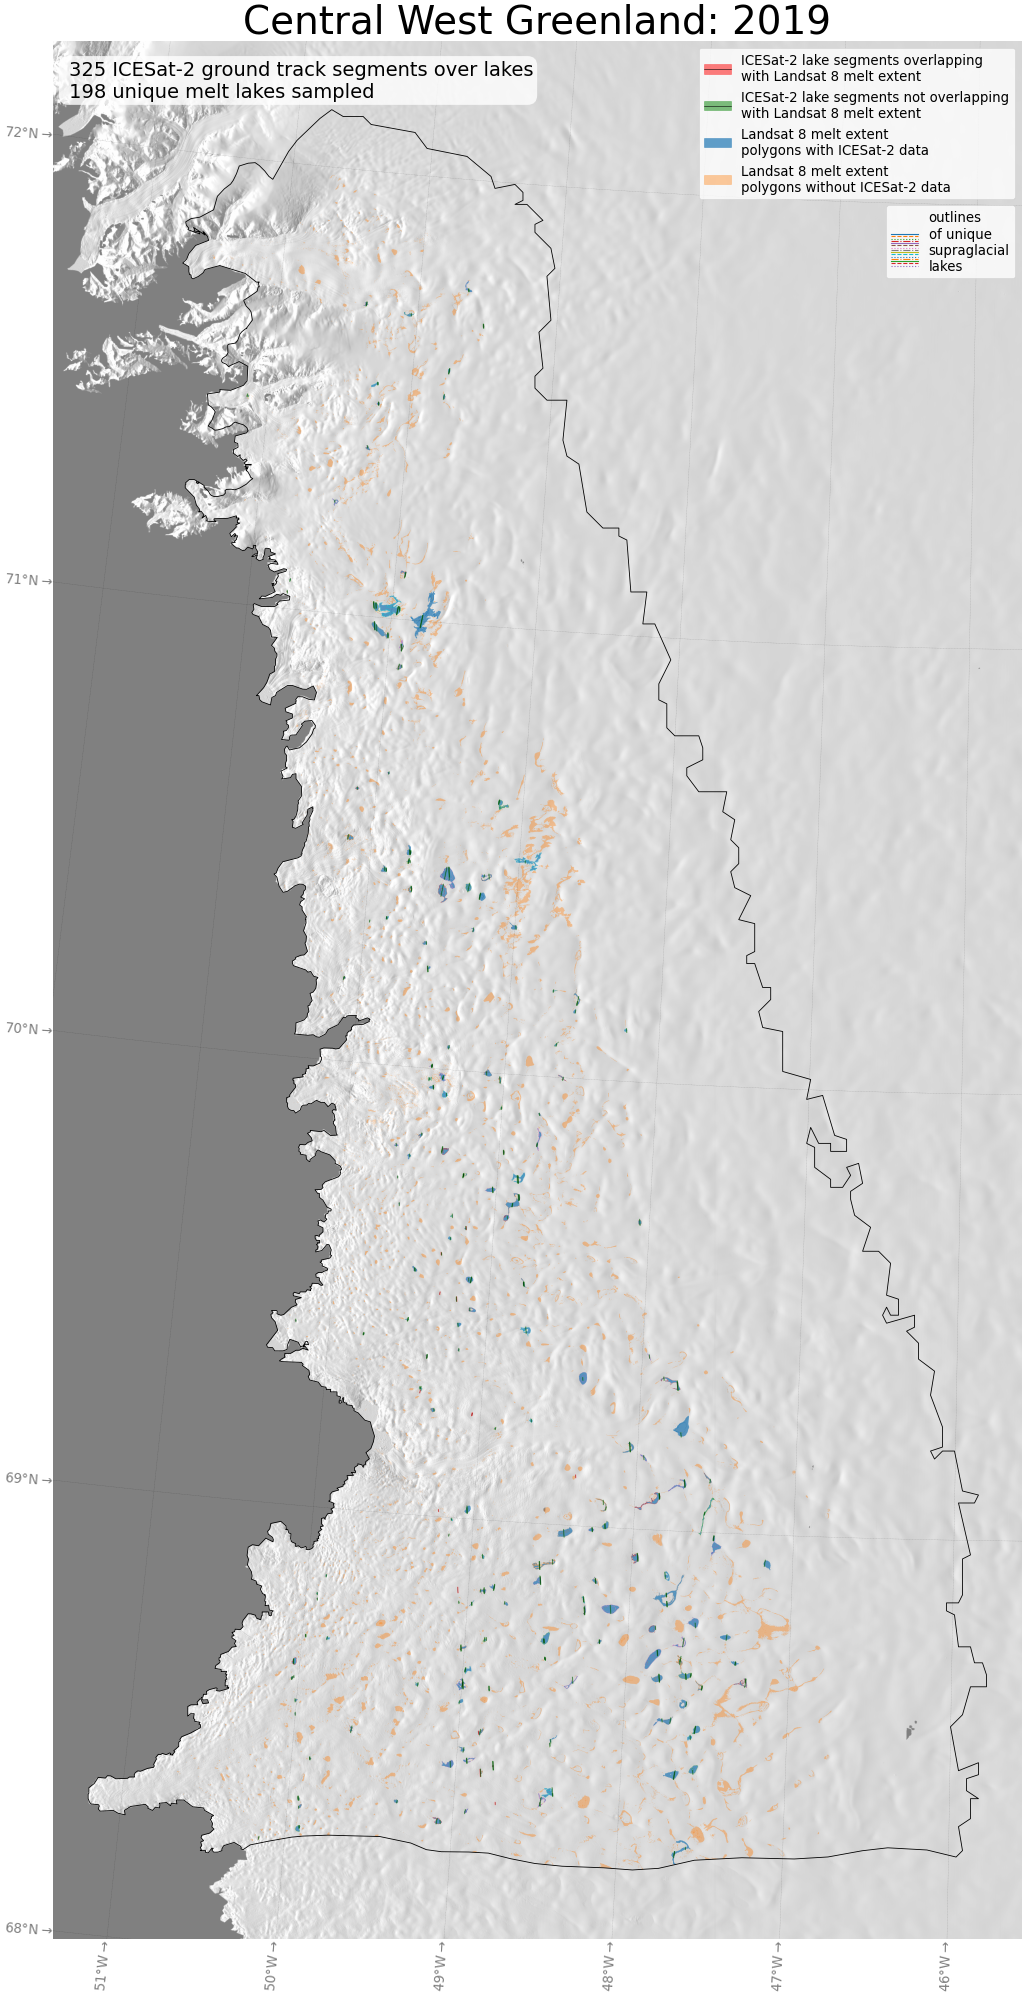

saved ../figures/supplemental_unique-lakes_CW_2020.jpg
wrote groupings_output/CW_2020_L8extent.csv
wrote groupings_output/CW_2020_unique_lakes_indices.csv
wrote groupings_output/CW_2020_is2_gts.csv


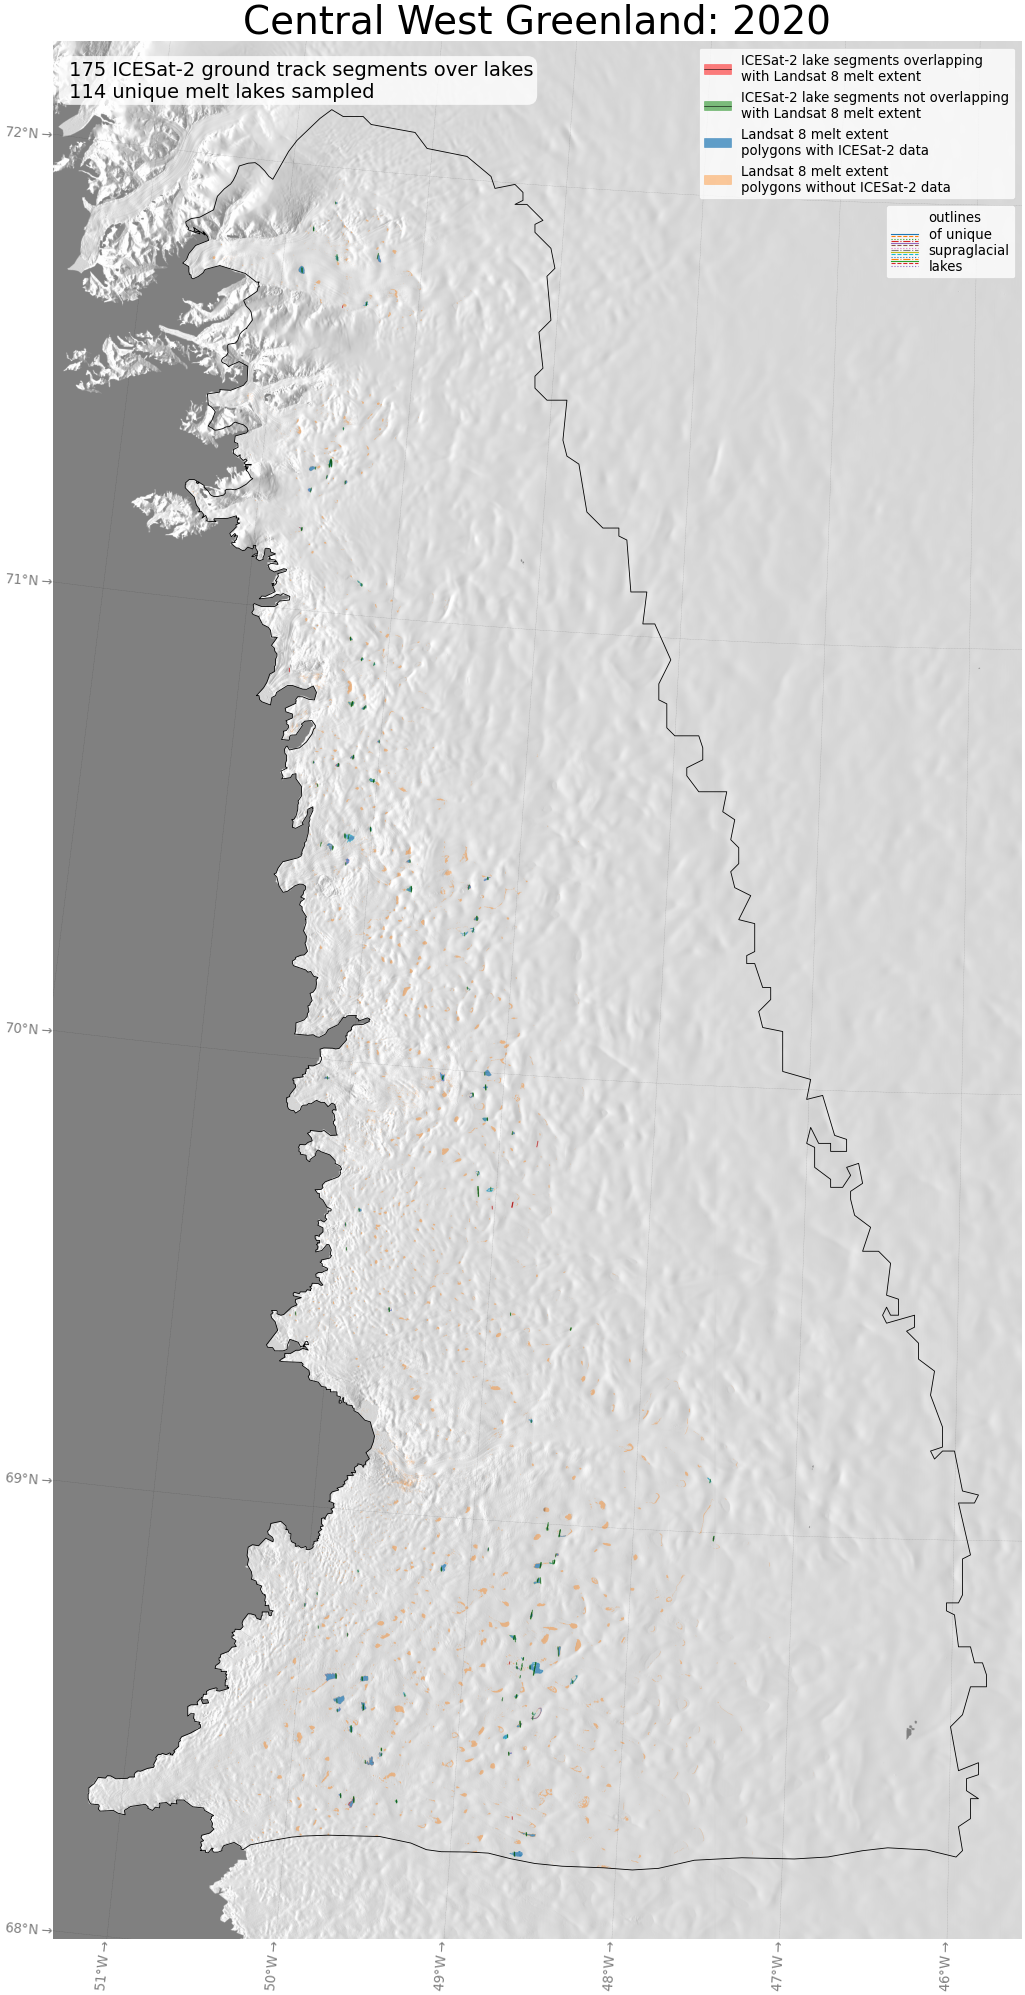

saved ../figures/supplemental_unique-lakes_B-C_2018-19.jpg
wrote groupings_output/B-C_2018-19_L8extent.csv
wrote groupings_output/B-C_2018-19_unique_lakes_indices.csv
wrote groupings_output/B-C_2018-19_is2_gts.csv


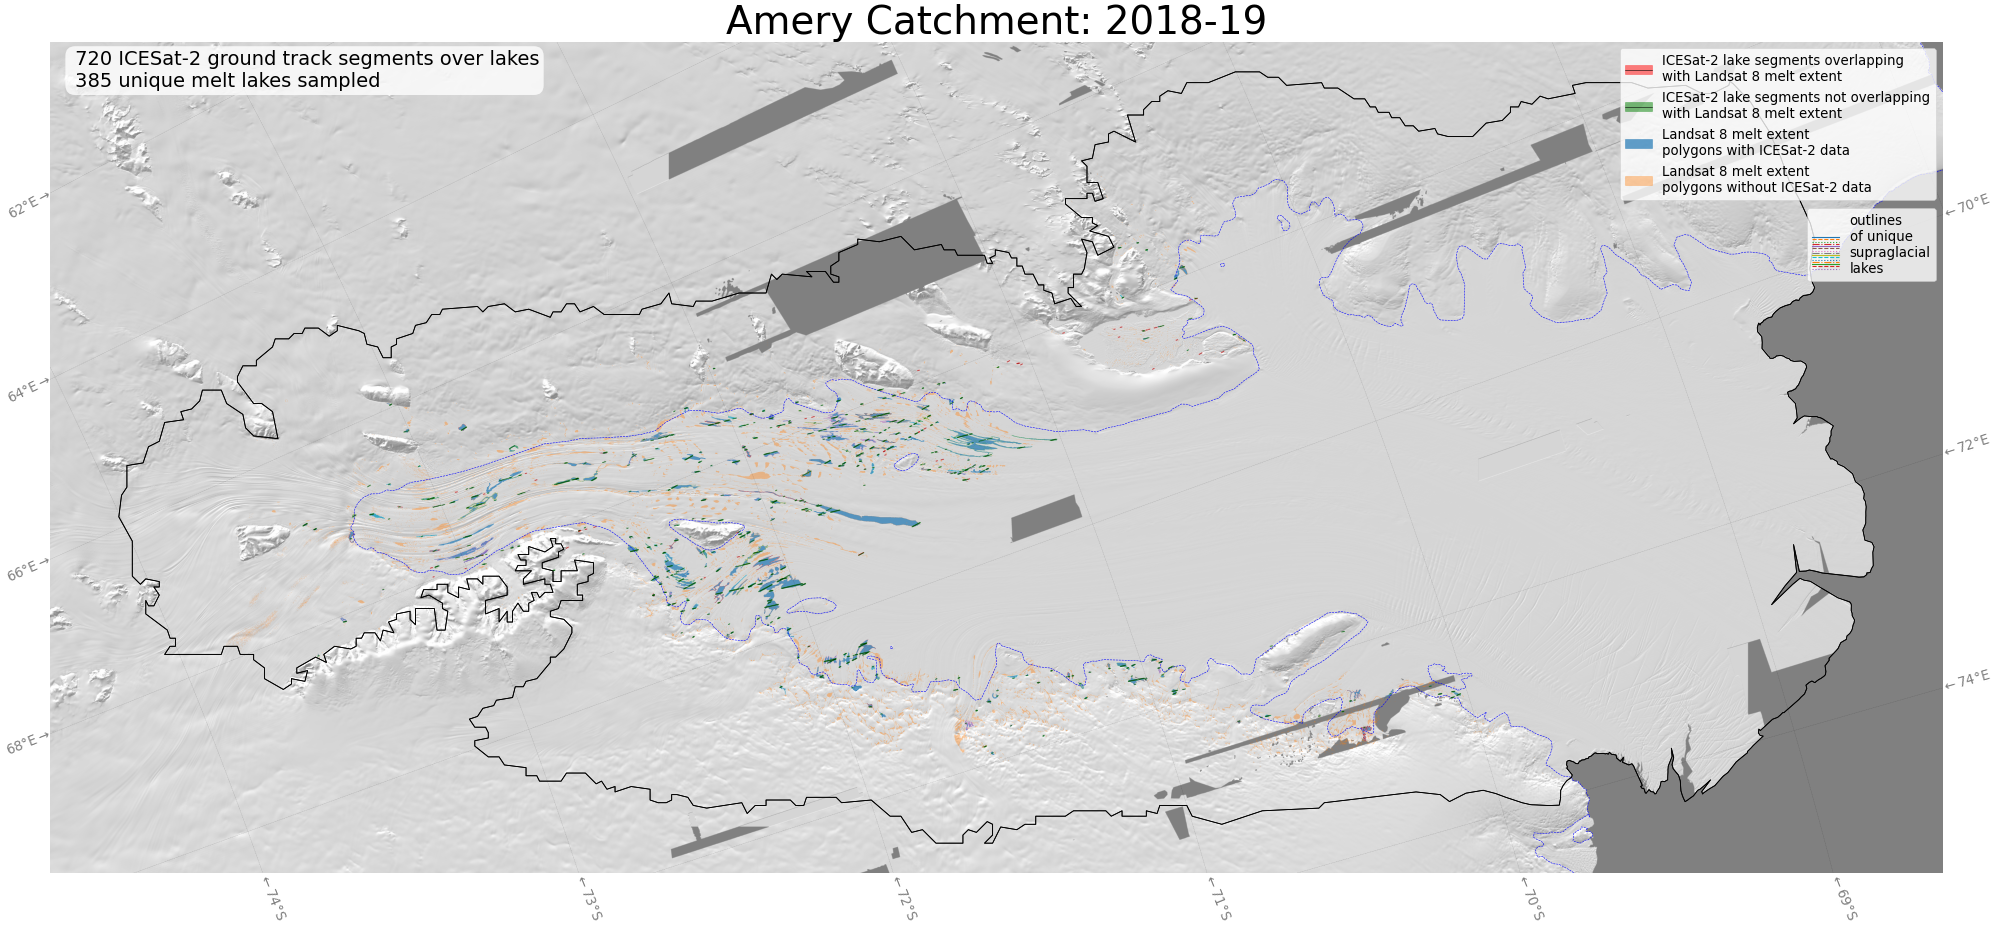

saved ../figures/supplemental_unique-lakes_B-C_2020-21.jpg
wrote groupings_output/B-C_2020-21_L8extent.csv
wrote groupings_output/B-C_2020-21_unique_lakes_indices.csv
wrote groupings_output/B-C_2020-21_is2_gts.csv


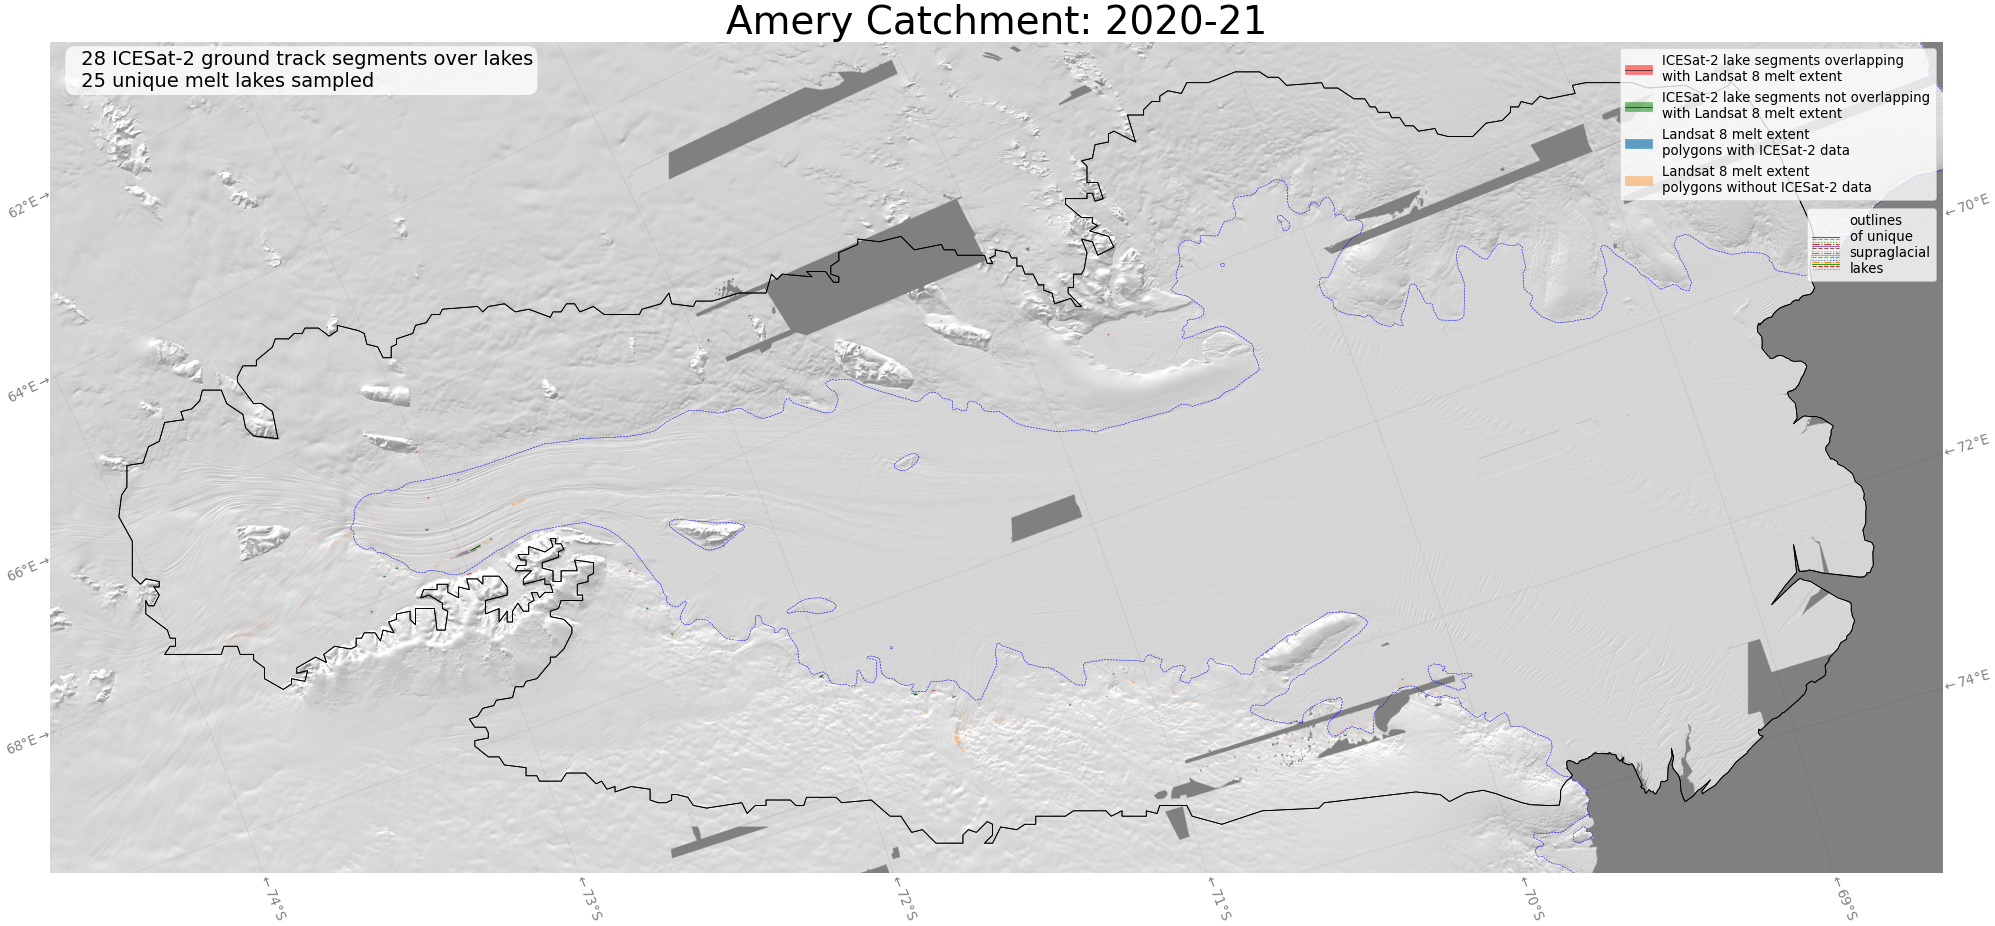

In [17]:
dpi_disp = 40
dpi_save = 600
is2green = '#65ff00'

seasons = {0: '2019', 1: '2020', 2: '2018-19', 3: '2020-21'}

## different-resolution DEMs for plotting
## 30-meter DEMs are not pushed to github, so change to one of the lower resolutions if not available
## can also use get_DEMs.js in Google Earth Engine to create DEMs (adding the data in data/shapefiles as Earth Engine Assets 
# dem_fn_dict = {'CW': 'data/DEMs/hillshade_export_CW_1k.tif', 'B-C': 'data/DEMs/hillshade_export_BC_1k.tif'}
# dem_fn_dict = {'CW': 'data/DEMs/hillshade_export_CW_100m.tif', 'B-C': 'data/DEMs/hillshade_export_BC_100m.tif'}
dem_fn_dict = {'CW': 'data/DEMs/hillshade_export_CW_30m.tif', 'B-C': 'data/DEMs/hillshade_export_BC_30m.tif'}

plt.close('all')
for i, season in seasons.items():

    # get data and parameters for this melt season
    ext = exts[i].copy()
    icrs = crss[int(i/2)]
    gti = gdf_gt[gdf_gt.melt_season == season].to_crs(icrs).reset_index(names='lake_idx').copy()
    region = gti.basin_name.iloc[0]
    name = 'Central West Greenland' if region == 'CW' else 'Amery Catchment'
    figsz = [30, 50] if region == 'CW' else [50, 30]
    rgt_lines = rgt_cw if region == 'CW' else rgt_bc

    # create figure
    fig, ax = plt.subplots(figsize=figsz, dpi=dpi_disp)

    # # plot RGTs
    # rgt_lines.plot(color=is2green, ax=ax, lw=0.1, zorder=1)

    # plot the ICESat-2 lake segment ground tracks that overlap and don't overlap with Landsat extents 
    pe = [path_effects.Stroke(capstyle="round")]
    gti[gti.intersects_with_extent].plot(ax=ax, color='g', lw=2, alpha=0.5, path_effects=pe, zorder=1000)
    gti[~gti.intersects_with_extent].plot(ax=ax, color='r', ls='-', lw=2, alpha=0.5, path_effects=pe, zorder=900)
    gti.plot(ax=ax, color='k', lw=0.3, zorder=2000)

    # get the outline of the study region
    if region == 'CW':
        region_thresh = gre_gdf_thresh[gre_gdf_thresh.SUBREGION1 == region]
    else: 
        region_thresh = ant_gdf_thresh[ant_gdf_thresh.Subregions == region]
    ext = ext.reset_index(drop=True)

    # figure out which extent lake outlines are crossed by ICESat-2 segments 
    gti['extent_idxs'] = [[] for j in range(len(gti))]
    ext['has_is2'] = False
    for j in gti.index:
        overlaps_gt = gti.loc[j,'geometry'].intersects(ext.geometry)
        ext.loc[overlaps_gt, 'has_is2'] = True
        gti.loc[j,'extent_idxs'].append(list(ext[overlaps_gt].index))
    gti['extent_idxs'] = [x[0] for x in gti.extent_idxs]

    # find unique lakes
    unique_lakes = find_unique_lakes(gti.extent_idxs)
    for iu in unique_lakes.index:
        ext.loc[unique_lakes.loc[iu,'IDs_extent'], 'ID_unique_lake'] = iu

    # merge unique matched lakes, and sort them south to north
    ext_over = ext[ext.has_is2].copy()
    ext_over['ysort'] = ext_over.apply(lambda x: np.max(x.geometry.exterior.coords.xy[1]), axis=1)
    ext_over = ext_over.dissolve('ID_unique_lake')
    ext_over = ext_over.sort_values(by='ysort').reset_index()
    ext_over['ID_unique_lake'] = ext_over.ID_unique_lake.astype(np.int64)

    # plot the extents that are crossed by ICESat-2 lake segments, and the ones that are not
    ext_over.plot(ax=ax, color='C0', alpha=0.7)
    ext[~ext.has_is2].plot(ax=ax, color='C1', alpha=0.4)

    # plot outlines of unique lakes in different colors and line styles
    nlines = len(ext_over)
    cols = matplotlib.colormaps['tab10'](np.arange(nlines) % 10)
    lst = ['-', '--', ':', '-.']
    lss = np.array(lst)[[int((x/10) % len(lst)) for x in range(nlines)]]
    hdls = []
    for j in range(len(cols)):
        try:
            ext_over.iloc[[j]].buffer(10).plot(ax=ax, facecolor='none', lw=0.3, edgecolor=cols[j], ls=lss[j], label='unique lake border')
        except:
            pass

    # add some line artists for the legend for unique lake outlines
    lss = [lst[j%len(lst)] for j in range(10)] + [lst[(j+2)%len(lst)] for j in range(5)]
    for j in range(len(lss)):
        h = Line2D([0], [0], color=cols[j], ls=lss[j], label='unique lake borders', lw=2)
        hdls.append(h)

    # for amery, add grounding line
    if region == 'B-C':
        region_thresh.exterior.plot(ax=ax, color='k')
        xl = ax.get_xlim()
        yl = ax.get_ylim()
        ant_gdf_ground.plot(ax=ax, edgecolor='b', facecolor='none', ls='--')
        ax.set_xlim(xl)
        ax.set_ylim(yl)
    region_thresh.exterior.plot(ax=ax, color='k')

    # Add the DEM
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    dem_fn = dem_fn_dict[region]
    with rio.open(dem_fn) as img_dem:
        rioplot.show(img_dem, cmap=cmc.grayC_r, alpha=0.5, ax=ax, zorder=0)
    fac = 0.01
    xl = (xl[0] + (xl[1]-xl[0]) * fac, xl[1] - (xl[1]-xl[0]) * fac)
    yl = (yl[0] + (yl[1]-yl[0]) * fac, yl[1] - (yl[1]-yl[0]) * fac)
    ax.set_xlim(xl)
    ax.set_ylim(yl)

    # add legends
    leg_fontsize = 24
    h_gt_yes = (mpatches.Patch(color='red', alpha=0.5), Line2D([], [], color='k', lw=1))
    h_gt_no = (mpatches.Patch(color='green', alpha=0.5), Line2D([], [], color='k', lw=1))
    h_l8_yes = mpatches.Patch(color='C0', alpha=0.7)
    h_l8_no = mpatches.Patch(color='C1', alpha=0.4)
    labels = [
        'ICESat-2 lake segments overlapping\nwith Landsat 8 melt extent',
        'ICESat-2 lake segments not overlapping\nwith Landsat 8 melt extent',
        'Landsat 8 melt extent\npolygons with ICESat-2 data',
        'Landsat 8 melt extent\npolygons without ICESat-2 data'
    ]
    handles = [h_gt_yes, h_gt_no, h_l8_yes, h_l8_no]
    leg1 = ax.legend(handles=handles, labels=labels, loc='upper right', fontsize=leg_fontsize)
    ax.add_artist(leg1)
    
    bbox = leg1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    bottom_y_extent_of_legend1 = bbox.y0 / fig.get_size_inches()[1]
    handles = [tuple(hdls)]
    offset = 0.003458 if region=='CW' else 0.008
    leg2 = ax.legend(handles=handles, labels=['outlines\nof unique\nsupraglacial\nlakes'], loc='upper right', fontsize=leg_fontsize, 
                     bbox_to_anchor=(1, 1 - offset * leg_fontsize), handler_map={tuple:HandlerLinesVertical()}, handleheight=3.5)

    # add unique lake stats as text
    txt = '%4i ICESat-2 ground track segments over lakes' % len(gti)
    txt += '\n%4i unique melt lakes sampled' % len(unique_lakes)
    ax.text(0.01, 0.99, txt, fontsize=35, transform=ax.transAxes, ha='left', va='top',
           bbox=dict(facecolor='white', alpha=0.8, lw=0, boxstyle='round,pad=0.2,rounding_size=0.5'))
    
    ax.set_title('%s: %s' % (name, season), fontsize=70)
    ax.axis('off')
    if region == 'CW':
        meridians_locs=['bottom']
        parallels_locs=['left']
    else:
        meridians_locs=['left', 'right']
        parallels_locs=['bottom']
        
    add_graticule(region_thresh, ax, fontsz=24, meridians_locs=meridians_locs,parallels_locs=parallels_locs)
    
    fig.tight_layout()

    figfn = '../figures/supplemental_unique-lakes_%s_%s.jpg' % (region, season)
    # print('save fig jpg')
    fig.savefig(figfn, dpi=dpi_save)
    dpi = 300
    fig.savefig('supplemental_test_unique-lakes_%s_%s_%idpi.jpg' % (region, season, dpi), dpi=dpi)
    # print('save fig pdf')
    # fig.savefig('supplemental_test_unique-lakes_%s_%s.pdf' % (region, season), dpi=150, format="pdf", bbox_inches="tight")
                
    print('saved %s' % figfn)

    # save plot extent to shapefile
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    bbx_df = pd.DataFrame({'x': [xl[j] for j in [0,1,1,0,0]], 'y': [yl[j] for j in [0,0,1,1,0]]})
    bbx_gdf = gpd.GeoDataFrame(bbx_df, geometry=gpd.points_from_xy(bbx_df.x, bbx_df.y), crs=gti.crs).to_crs('EPSG:4326')
    bbx_gdf = gpd.GeoDataFrame(index=[0], crs=bbx_gdf.crs, geometry=[Polygon(bbx_gdf['geometry'].tolist())])
    bbx_gdf.to_file('data/shapefiles/%s-bbox.shp' % region)

    extfn = 'groupings_output/%s_%s_L8extent.csv' % (region, season)
    ext_over.to_csv(extfn)
    print('wrote %s' % extfn)

    ulfn = 'groupings_output/%s_%s_unique_lakes_indices.csv' % (region, season)
    unique_lakes.to_csv(ulfn)
    print('wrote %s' % ulfn)

    gtifn = 'groupings_output/%s_%s_is2_gts.csv' % (region, season)
    gti.to_csv(gtifn)
    print('wrote %s' % gtifn)

    plt.close(fig)
    display(fig)